In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
sns.set_style("whitegrid")

Our next task is to get the "opening" cutoff week for each movie based on the threshold from the box office data

# Loading and Cleaning Box Office Data

In [2]:
boxOffice = pickle.load( open( "LeapReallyCleanedBoxofficeData.p", "rb" ) )

# titles = list(boxOffice.keys())
# stringVal = False
# badOrder = 0
# for title in titles:
#     movieData = boxOffice[title]
#     # Remove entries with no weekly gross data, number of theaters, or with fewer than three reported weeks
#     if ('Weekly' not in movieData.columns) or ('-' in movieData.Theaters.values) or (True in pd.isna(movieData.Theaters.values)) or (int(max(movieData.Week))<=3) or (movieData.Week.iloc[0]!=1):
#         print(title)
#         del boxOffice[title]
#     # A few movies have special opening weekends which open very small. I've excluded them
#     # elif (type(movieData.Week.values[0])==str):
#     #     print(title)
#     #     del boxOffice[title]

# # pickle.dump( boxOffice, open( "CleanedBoxofficeData.p", "wb" ) )

# Compute the Opening Week Cutoff and Multiplier for each movie

In [3]:
multiplierDataFrame = pd.DataFrame(columns=('title', 'Opening Week', 'Opening Week Number', 'Multiplier'))
i=0
threshold = 0.6
for title in boxOffice:
    cleanTitle = title.split(' (')[0] # Remove Year Tag
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    startingWeek = boxOffice[title][boxOffice[title].Theaters>=threshold*widestWeek].Week.min()
    # weekCutoffs[cleanTitle] = pd.to_datetime(boxOffice[title].at[startingWeek, 'Date'])
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
    multiplierDataFrame.loc[i] = [cleanTitle, pd.to_datetime(boxOffice[title].at[startingWeek, 'Date']), startingWeek, multiplier]
    i+=1
multiplierDataFrame

,title,Opening Week,Opening Week Number,Multiplier
0,Alien,1979-06-22,5,2.416036
1,Raging Bull,1980-12-19,6,1.000000
2,Star Wars: Episode V - The Empire Strikes Back,1980-06-20,6,1.590517
3,Modern Problems,1981-12-25,1,3.600396
4,On Golden Pond,1982-02-12,11,3.246197
...,...,...,...,...
6145,Companion,2025-01-31,1,1.669133
6146,Green and Gold,2025-01-31,1,1.561074
6147,Den of Thieves: Pantera,2025-01-10,1,1.839845
6148,Presence,2025-01-24,1,1.518704


In [4]:
# read in review and movie data into data frames
dfs = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_scale.csv', index_col=False)
dfm = pd.read_csv('./cleandata/rotten_tomatoes_movies_clean.csv', index_col=False)

rottenMovies = dfm.filter(['id', 'title']) # One line per movie with id, title, and "Release Date"
rottenReviews = dfs.filter(['id', 'creationDate', 'isTopCritic', 'originalScore']) # One line per review with normalized score, etc.
rottenReviews['binaryScore'] = [0 if sS == "NEGATIVE" else 1 for sS in dfs['scoreSentiment']] # Convert sentiment to numerical value
movie_ids_winfo = pd.unique(rottenMovies['id']).tolist() # unique list of movie ids from movie list

rottenReviewsWithTitles = rottenReviews.merge(rottenMovies, how='inner', on='id')
rottenReviewsWithMultipliers = rottenReviewsWithTitles.merge(multiplierDataFrame, how='inner', on='title')
rottenReviewsWithMultipliers['creationDate'] = pd.to_datetime(rottenReviewsWithMultipliers['creationDate'])
rottenReviewsWithMultipliers

,id,creationDate,isTopCritic,originalScore,binaryScore,title,Opening Week,Opening Week Number,Multiplier
0,addicted_2014,2019-09-06,False,0.200,0,Addicted,2014-10-10,1,1.855915
1,addicted_2014,2015-01-09,False,0.000,0,Addicted,2014-10-10,1,1.855915
2,addicted_2014,2014-10-16,True,0.425,0,Addicted,2014-10-10,1,1.855915
3,addicted_2014,2014-10-11,True,0.375,0,Addicted,2014-10-10,1,1.855915
4,addicted_2014,2014-10-10,True,0.300,0,Addicted,2014-10-10,1,1.855915
...,...,...,...,...,...,...,...,...,...
469830,thor_love_and_thunder,2022-07-05,False,0.700,1,Thor: Love and Thunder,2022-07-08,1,1.832940
469831,thor_love_and_thunder,2022-07-05,False,0.800,1,Thor: Love and Thunder,2022-07-08,1,1.832940
469832,thor_love_and_thunder,2022-07-05,False,0.800,1,Thor: Love and Thunder,2022-07-08,1,1.832940
469833,thor_love_and_thunder,2022-07-05,True,0.250,0,Thor: Love and Thunder,2022-07-08,1,1.832940


In [5]:
# for series in multiplierDataFrame['Opening Week'].values:
#     if isinstance(series,pd.Series):
#         print(series)
# multiplierDataFrame.head()

# for index, row in multiplierDataFrame.iterrows():
#     if isinstance(row['Opening Week'],pd.Series):
#         print(row['title'])
# multiplierDataFrame[multiplierDataFrame.title=='The Band\'s Visit']
# rottenReviewsWithMultipliers['Opening Week'].apply(type)

In [6]:
earlyReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']]
earlyTopReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[(rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']) \
 & (rottenReviewsWithMultipliers.isTopCritic)]

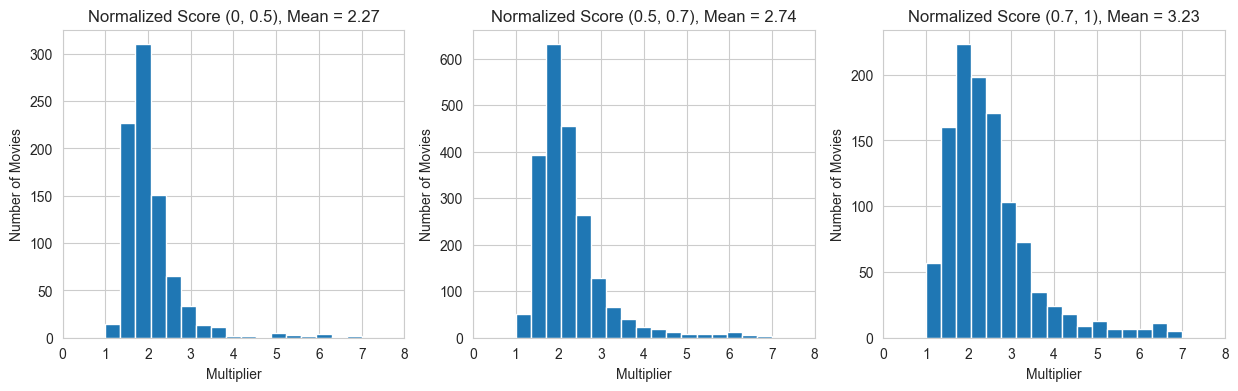

In [7]:
# Note the possible problem handling movies with identical titles
avgEarlyReviews = earlyReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].set_title('Normalized Score (0, 0.5), Mean = %.2f' %avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0, 0.5)].Multiplier.mean())
ax[1].set_title('Normalized Score (0.5, 0.7), Mean = %.2f' %avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.5, 0.7)].Multiplier.mean())
ax[2].set_title('Normalized Score (0.7, 1), Mean = %.2f' %avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.7, 1)].Multiplier.mean())
ax[0].hist(avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0, 0.5)].Multiplier, bins=np.linspace(1, 7, 18))
ax[1].hist(avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.4, 0.7)].Multiplier, bins=np.linspace(1, 7, 18))
ax[2].hist(avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.7, 1)].Multiplier, bins=np.linspace(1, 7, 18))
for i in range(3):
    ax[i].set_xlim([0, 8])
    ax[i].set_xlabel('Multiplier')
    ax[i].set_ylabel('Number of Movies')
# avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.2, 0.4)].Multiplier
# avgEarlyReviews.dropna()

(-0.1, 1.1)

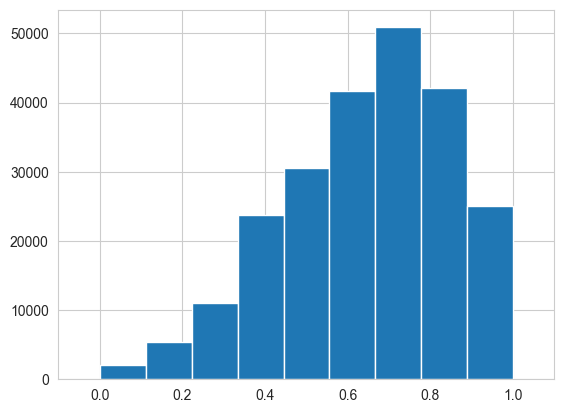

In [8]:
earlyReviewsWithMultipliers.originalScore.hist(bins=np.linspace(0, 1, 10))
plt.xlim([-.1, 1.1])